In [1]:
import pandas as pd
import numpy as np
# allow multiple outputs per cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Load Treated dataset from EDA

In [2]:
df = pd.read_csv("ad_clicks_100k_Treated.csv")
df.drop(columns="Unnamed: 0", inplace=True)
df.head()
df.shape

,id,click,hour,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,...,C15,C16,C17,C18,C19,C20,C21,hour_of_day,day,weekday
0,6.448465e+18,0,2014-10-28 06:00:00,1005,0,d6137915,bb1ef334,f028772b,ecad2386,7801e8d9,...,320,50,2227,0,935,-1,48,6,28,Tuesday
1,1.342805e+19,0,2014-10-23 07:00:00,1002,0,85f751fd,c4e18dd6,50e219e0,9a08a110,7801e8d9,...,320,50,2495,2,167,-1,23,7,23,Thursday
2,1.048699e+19,0,2014-10-23 10:00:00,1005,0,9a28a858,64778742,f028772b,ecad2386,7801e8d9,...,300,250,2523,3,39,-1,221,10,23,Thursday
3,8.833733e+18,0,2014-10-23 07:00:00,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,...,320,50,1722,0,35,-1,79,7,23,Thursday
4,1.035453e+19,0,2014-10-28 11:00:00,1005,0,85f751fd,c4e18dd6,50e219e0,a5184c22,b8d325c3,...,320,50,2676,0,35,100176,221,11,28,Tuesday


(100000, 27)

### Drop features that will not go into the model
- `id` (We do not need the variable ID as predictor, it does not make sense to use)
- `hour` (because hour was broken down into (day, weekday, hour_of_day)) 
- `day` (because we find that it will add no significant predictive value that makes sense in any future application, i.e. the dataset covers 10 days of the year and we have no way to know if any of those days is representative of the year, or if there was something exceptional happening. By using `hour_of_day` and `weekday` we average these values and thus make this possible effect less significant)   
- `device_ip` and `device_id`

In [3]:
df.drop(columns=['id','hour','device_ip','device_id','day'], inplace=True)
df.head()
df.shape

,click,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,app_category,device_model,...,C14,C15,C16,C17,C18,C19,C20,C21,hour_of_day,weekday
0,0,1005,0,d6137915,bb1ef334,f028772b,ecad2386,7801e8d9,07d7df22,9efa421a,...,19771,320,50,2227,0,935,-1,48,6,Tuesday
1,0,1002,0,85f751fd,c4e18dd6,50e219e0,9a08a110,7801e8d9,07d7df22,02d14ecc,...,21676,320,50,2495,2,167,-1,23,7,Thursday
2,0,1005,0,9a28a858,64778742,f028772b,ecad2386,7801e8d9,07d7df22,ecb851b2,...,21837,300,250,2523,3,39,-1,221,10,Thursday
3,0,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,07d7df22,779d90c2,...,15706,320,50,1722,0,35,-1,79,7,Thursday
4,0,1005,0,85f751fd,c4e18dd6,50e219e0,a5184c22,b8d325c3,0f2161f8,dc15c87e,...,23224,320,50,2676,0,35,100176,221,11,Tuesday


(100000, 22)

## Pre-processing:
- One Hot encoding for low cardinality features (1 to 5 unique categories)
- Label encoding for medium cardinality features (5 to 100 unique categories)
- Target encoding for high cardinality features (100+ unique categories)
    - (Since it has to be done within Cross Validation we will filter and add to a list the features we consider to have high cardinality)

- Numerical Features: `hour_of_day` will not be encoded (it already is a discrete variable)

In [4]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.compose import make_column_transformer

In [5]:
# Split into features type "O" and already encoded features
categorical_columns = [i for i in list(df.columns) if df[i].dtypes in ["O"] and i not in ['id','hour','hour_of_day','click']]
encoded_categorical_columns = [i for i in list(df.columns) if df[i].dtypes not in ["O"] and i not in ['id','hour','hour_of_day','click']]
print(f'Features with dtype "O" {categorical_columns}')
print(f'Categorical Features (already with discrete values) {encoded_categorical_columns}')


Features with dtype "O" ['site_id', 'site_domain', 'site_category', 'app_id', 'app_domain', 'app_category', 'device_model', 'weekday']
Categorical Features (already with discrete values) ['C1', 'banner_pos', 'device_type', 'device_conn_type', 'C14', 'C15', 'C16', 'C17', 'C18', 'C19', 'C20', 'C21']


In [6]:
# Transform features type "O" with label encoder
for i in categorical_columns:
    label_encoder = []
    le = LabelEncoder()
    le.fit(df[i])    
    label_encoder.append(le)
    df[i] = le.transform(df[i])

all_features = categorical_columns + encoded_categorical_columns
print(all_features)

LabelEncoder()

LabelEncoder()

LabelEncoder()

LabelEncoder()

LabelEncoder()

LabelEncoder()

LabelEncoder()

LabelEncoder()

['site_id', 'site_domain', 'site_category', 'app_id', 'app_domain', 'app_category', 'device_model', 'weekday', 'C1', 'banner_pos', 'device_type', 'device_conn_type', 'C14', 'C15', 'C16', 'C17', 'C18', 'C19', 'C20', 'C21']


## Apply 
- One Hot encoding for low cardinality features (1 to 5 unique categories)
- Label encoding for medium cardinality features (5 to 100 unique categories)
- Target encoding for high cardinality features (100+ unique categories)

In [7]:
data = df.copy()
one_hot = []
label_enc = []
target_enc = []
for i in all_features:
    if len(df[i].unique()) <= 5:
        # One hot encoding
        one_hot.append(i)
        data = pd.concat([data, pd.get_dummies(df[i], prefix=i)],axis=1)
        # Drop the original column
        data.drop(columns=[i], inplace=True)
    elif 100 >= len(df[i].unique()) > 5:
        # Label encoding
        label_enc.append(i)
    elif len(df[i].unique()) > 100:
        # Mean encoding
        target_enc.append(i)

print('Previus Dataset Shape ->> ', df.shape)
print('Shape After Encoding  ->> ', data.shape, '\n')
print(f'One Hot Encoding the following features: {one_hot}')
print(f'Label Encoding the following features: {label_enc}')
print(f'Selected for Target Encoding: {target_enc}')
data.head()

Previus Dataset Shape ->>  (100000, 22)
Shape After Encoding  ->>  (100000, 31) 

One Hot Encoding the following features: ['device_type', 'device_conn_type', 'C18']
Label Encoding the following features: ['site_category', 'app_domain', 'app_category', 'weekday', 'C1', 'banner_pos', 'C15', 'C16', 'C19', 'C21']
Selected for Target Encoding: ['site_id', 'site_domain', 'app_id', 'device_model', 'C14', 'C17', 'C20']


,click,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,app_category,device_model,...,device_type_4,device_type_5,device_conn_type_0,device_conn_type_2,device_conn_type_3,device_conn_type_5,C18_0,C18_1,C18_2,C18_3
0,0,1005,0,1215,998,17,1195,41,0,1956,...,0,0,1,0,0,0,1,0,0,0
1,0,1002,0,770,1043,5,783,41,0,36,...,0,0,1,0,0,0,0,0,1,0
2,0,1005,0,890,535,17,1195,41,0,2936,...,0,0,1,0,0,0,0,0,0,1
3,0,1005,0,167,1261,1,1195,41,0,1476,...,0,0,1,0,0,0,1,0,0,0
4,0,1005,0,770,1043,5,842,67,3,2746,...,0,0,0,1,0,0,1,0,0,0


In [8]:
data.columns

Index(['click', 'C1', 'banner_pos', 'site_id', 'site_domain', 'site_category',
       'app_id', 'app_domain', 'app_category', 'device_model', 'C14', 'C15',
       'C16', 'C17', 'C19', 'C20', 'C21', 'hour_of_day', 'weekday',
       'device_type_0', 'device_type_1', 'device_type_4', 'device_type_5',
       'device_conn_type_0', 'device_conn_type_2', 'device_conn_type_3',
       'device_conn_type_5', 'C18_0', 'C18_1', 'C18_2', 'C18_3'],
      dtype='object')

## Lets take a closer look at the high cardinality features

In [9]:
for i in target_enc:
    print(f'{i} has {len(data[i].unique())} unique categories')

site_id has 1461 unique categories
site_domain has 1333 unique categories
app_id has 1296 unique categories
device_model has 3167 unique categories
C14 has 1713 unique categories
C17 has 399 unique categories
C20 has 157 unique categories


## Split the Dataset

In [10]:
from sklearn.model_selection import train_test_split

X = data.drop(columns=['click'])
y = data['click']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)
X_train.shape
y_train.shape
X_test.shape
y_test.shape

(80000, 30)

(80000,)

(20000, 30)

(20000,)

# Modeling

In [11]:
# Imports
from imblearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import RandomOverSampler
from sklearn.linear_model import LogisticRegression
from imblearn.under_sampling import RandomUnderSampler
import numpy as np
from category_encoders.target_encoder import TargetEncoder

from sklearn.model_selection import train_test_split
from imblearn.pipeline import make_pipeline 
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, f1_score, make_scorer, accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.model_selection import cross_validate
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt

# Ensemble methods
from sklearn.tree import DecisionTreeClassifier 
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier

# Boosting 
from catboost import CatBoostClassifier

# Stats (util)
from scipy.stats import randint as sp_randInt
from scipy.stats import uniform as sp_randFloat

## KNN Classifier

In [12]:
pipe = Pipeline([('sampling', RandomOverSampler()), 
                 ('transformer', TargetEncoder(cols=target_enc)),
                 ('scaler', StandardScaler()), 
                 ('classifier', KNeighborsClassifier())])
param_grid = [
    {'classifier': [KNeighborsClassifier()], 
     'scaler': [StandardScaler()],
     'transformer': [TargetEncoder(cols=target_enc)],
     'sampling': [RandomUnderSampler(), RandomOverSampler(), SMOTE()],
     'classifier__n_neighbors': [2, 3, 4, 5],
     'classifier__weights': ['uniform', 'distance']}, 
]
knn_grid = GridSearchCV(pipe, param_grid, cv=10, scoring = 'f1')
knn_grid.fit(X_train, y_train)
knn_model = knn_grid.best_estimator_
print("Best cross-validation score: {:.2f}".format(knn_grid.best_score_))
print("Best params:\n{}\n".format(knn_grid.best_params_))

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('sampling', RandomOverSampler()),
                                       ('transformer',
                                        TargetEncoder(cols=['site_id',
                                                            'site_domain',
                                                            'app_id',
                                                            'device_model',
                                                            'C14', 'C17',
                                                            'C20'])),
                                       ('scaler', StandardScaler()),
                                       ('classifier', KNeighborsClassifier())]),
             param_grid=[{'classifier': [KNeighborsClassifier()],
                          'classifier__n_neighbors': [2, 3, 4, 5],
                          'classifier__weights': ['uniform', 'distance'],
                          'sampling': [RandomUnderSampler(

Best cross-validation score: 0.36
Best params:
{'classifier': KNeighborsClassifier(), 'classifier__n_neighbors': 5, 'classifier__weights': 'uniform', 'sampling': RandomUnderSampler(), 'scaler': StandardScaler(), 'transformer': TargetEncoder(cols=['site_id', 'site_domain', 'app_id', 'device_model', 'C14',
                    'C17', 'C20'])}



In [13]:
knn_best_params = {'classifier': KNeighborsClassifier(), 
                   'classifier__n_neighbors': 5, 
                   'classifier__weights': 'uniform', 
                   'sampling': RandomUnderSampler(), 
                   'scaler': StandardScaler(), 
                   'transformer': TargetEncoder(cols=['site_id', 'site_domain', 'app_id', 'device_model', 'C14', 'C17', 'C20'])}

# RANDOM FOREST

## Simple Random Forest

In [34]:
pipe = Pipeline([('sampling', RandomOverSampler()), 
                 ('transformer', TargetEncoder(cols=target_enc)),
                 ('scaler', StandardScaler()), 
                 ('classifier', RandomForestClassifier())])
param_grid = [
    {'classifier': [RandomForestClassifier()], 
     'scaler': [StandardScaler()],
     'transformer': [TargetEncoder(cols=target_enc)],
     'sampling': [None, RandomUnderSampler(), RandomOverSampler(), SMOTE()]}
]
rfc_simple_grid = GridSearchCV(pipe, param_grid, cv=10, scoring = 'f1')
rfc_simple_grid.fit(X_train, y_train)
rfc_model = rfc_simple_grid.best_estimator_
print("Best cross-validation scorerfc__simple_grid".format(rfc_simple_grid.best_score_))
print("Best pararfc__simple_gridn".format(rfc_simple_grid.best_params_))

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('sampling', RandomOverSampler()),
                                       ('transformer',
                                        TargetEncoder(cols=['site_id',
                                                            'site_domain',
                                                            'app_id',
                                                            'device_model',
                                                            'C14', 'C17',
                                                            'C20'])),
                                       ('scaler', StandardScaler()),
                                       ('classifier',
                                        RandomForestClassifier())]),
             param_grid=[{'classifier': [RandomForestClassifier()],
                          'sampling': [None, RandomUnderSampler(),
                                       RandomOverSampler(), SMOTE()],
                  

Best cross-validation scorerfc__simple_grid
Best pararfc__simple_gridn


## Hyper-parameter Tunning of Random Forest

In [24]:
pipe = Pipeline([('sampling', RandomOverSampler()), 
                 ('transformer', TargetEncoder(cols=target_enc)),
                 ('scaler', StandardScaler()), 
                 ('classifier', RandomForestClassifier())])
param_grid = [
    {'classifier': [RandomForestClassifier()], 
     'scaler': [StandardScaler()],
     'transformer': [TargetEncoder(cols=target_enc)],
     'sampling': [RandomUnderSampler(), RandomOverSampler(), SMOTE()],
     'classifier__n_estimators': sp_randInt(100, 1000),
     'classifier__max_depth': sp_randInt(1, 50),
     'classifier__min_samples_split': sp_randInt(1, 50),
     'classifier__min_samples_leaf': sp_randInt(1, 50)}, 
]
rfc_rand = RandomizedSearchCV(pipe, param_grid, cv=10, scoring = 'f1', n_iter=5, random_state=42)
rfc_rand.fit(X_train, y_train)
rfc_model = rfc_rand.best_estimator_
print("Best cross-validation score: {:.2f}".format(rfc_rand.best_score_))
print("Best params:\n{}\n".format(rfc_rand.best_params_))

RandomizedSearchCV(cv=10,
                   estimator=Pipeline(steps=[('sampling', RandomOverSampler()),
                                             ('transformer',
                                              TargetEncoder(cols=['site_id',
                                                                  'site_domain',
                                                                  'app_id',
                                                                  'device_model',
                                                                  'C14', 'C17',
                                                                  'C20'])),
                                             ('scaler', StandardScaler()),
                                             ('classifier',
                                              RandomForestClassifier())]),
                   n_iter=5,
                   param_distributions=[{'classifier': [RandomForestClassifier(max_depth=39,
                             

Best cross-validation score: 0.40
Best params:
{'classifier': RandomForestClassifier(max_depth=39, min_samples_leaf=29, min_samples_split=15,
                       n_estimators=206), 'classifier__max_depth': 39, 'classifier__min_samples_leaf': 29, 'classifier__min_samples_split': 15, 'classifier__n_estimators': 206, 'sampling': RandomUnderSampler(), 'scaler': StandardScaler(), 'transformer': TargetEncoder(cols=['site_id', 'site_domain', 'app_id', 'device_model', 'C14',
                    'C17', 'C20'])}



In [ ]:
rf_best_params = {'classifier': RandomForestClassifier(max_depth=39, min_samples_leaf=29, min_samples_split=15,
                       n_estimators=206), 'classifier__max_depth': 39, 'classifier__min_samples_leaf': 29, 
                       'classifier__min_samples_split': 15, 'classifier__n_estimators': 206, 'sampling': RandomUnderSampler(), 
                       'scaler': StandardScaler(), 'transformer': TargetEncoder(cols=['site_id', 'site_domain', 'app_id', 'device_model', 'C14', 'C17', 'C20'])}

# CATBOOST

In [26]:
catb = Pipeline([('sampling', RandomUnderSampler()),
                 ('transformer', TargetEncoder(cols=target_enc)),
                 ('scaler', StandardScaler()),
                 ('classifier', CatBoostClassifier(verbose=False, auto_class_weights='Balanced', early_stopping_rounds=10))])

param_grid= [
        {'classifier': [CatBoostClassifier(verbose=False, auto_class_weights='Balanced', early_stopping_rounds=10)],
         'scaler': [StandardScaler()],
         'transformer': [TargetEncoder(cols=target_enc)],
         'sampling': [RandomUnderSampler()], #, RandomOverSampler(), SMOTE()],
         'classifier__learning_rate': sp_randFloat(0, 1),
         'classifier__depth': sp_randInt(1, 10),
         'classifier__l2_leaf_reg': sp_randInt(1,10)}]

catb_rand = RandomizedSearchCV(catb, param_grid, cv=10, scoring = 'f1', n_iter=10, random_state=42)
catb_rand.fit(X_train, y_train)
catb_model = catb_rand.best_estimator_
print("Best cross-validation score: {:.2f}".format(catb_rand.best_score_))
print("Best params:\n{}\n".format(catb_rand.best_params_))

RandomizedSearchCV(cv=10,
                   estimator=Pipeline(steps=[('sampling', RandomUnderSampler()),
                                             ('transformer',
                                              TargetEncoder(cols=['site_id',
                                                                  'site_domain',
                                                                  'app_id',
                                                                  'device_model',
                                                                  'C14', 'C17',
                                                                  'C20'])),
                                             ('scaler', StandardScaler()),
                                             ('classifier',
                                              <catboost.core.CatBoostClassifier object at 0x0000021D2126AE20>)]),
                   param_distributions=[{'classifier': [<catboost.core.CatB...
                                

Best cross-validation score: 0.39
Best params:
{'classifier': <catboost.core.CatBoostClassifier object at 0x0000021D2117A5B0>, 'classifier__depth': 8, 'classifier__l2_leaf_reg': 3, 'classifier__learning_rate': 0.020584494295802447, 'sampling': RandomUnderSampler(), 'scaler': StandardScaler(), 'transformer': TargetEncoder(cols=['site_id', 'site_domain', 'app_id', 'device_model', 'C14',
                    'C17', 'C20'])}



In [33]:
knn_grid.best_params_
rfc_simple_grid.best_params_
rfc_rand.best_params_
catb_rand.best_params_

{'classifier': KNeighborsClassifier(),
 'classifier__n_neighbors': 5,
 'classifier__weights': 'uniform',
 'sampling': RandomUnderSampler(),
 'scaler': StandardScaler(),
 'transformer': TargetEncoder(cols=['site_id', 'site_domain', 'app_id', 'device_model', 'C14',
                     'C17', 'C20'])}

{'classifier': RandomForestClassifier(),
 'sampling': RandomUnderSampler(),
 'scaler': StandardScaler(),
 'transformer': TargetEncoder(cols=['site_id', 'site_domain', 'app_id', 'device_model', 'C14',
                     'C17', 'C20'])}

{'classifier': RandomForestClassifier(max_depth=39, min_samples_leaf=29, min_samples_split=15,
                        n_estimators=206),
 'classifier__max_depth': 39,
 'classifier__min_samples_leaf': 29,
 'classifier__min_samples_split': 15,
 'classifier__n_estimators': 206,
 'sampling': RandomUnderSampler(),
 'scaler': StandardScaler(),
 'transformer': TargetEncoder(cols=['site_id', 'site_domain', 'app_id', 'device_model', 'C14',
                     'C17', 'C20'])}

{'classifier': <catboost.core.CatBoostClassifier at 0x21d2117a5b0>,
 'classifier__depth': 8,
 'classifier__l2_leaf_reg': 3,
 'classifier__learning_rate': 0.020584494295802447,
 'sampling': RandomUnderSampler(),
 'scaler': StandardScaler(),
 'transformer': TargetEncoder(cols=['site_id', 'site_domain', 'app_id', 'device_model', 'C14',
                     'C17', 'C20'])}

# Choose Best Model

Using GridSearchCV we choose the best model after Hyper-parameter tunning. The metric we are using to make our decision regarding which is the best model is `f1-score`

In [45]:
best_pipe = Pipeline([('sampling', RandomUnderSampler()),
                 ('transformer', TargetEncoder(cols=target_enc)),
                 ('scaler', StandardScaler()),
                 ('classifier', KNeighborsClassifier())])

param_grid= [{key: [value] for (key, value) in knn_grid.best_params_.items()}, 
             {key: [value] for (key, value) in rfc_simple_grid.best_params_.items()},
             {key: [value] for (key, value) in rfc_rand.best_params_.items()},
             {key: [value] for (key, value) in catb_rand.best_params_.items()}]

originalclass = []
predictedclass = []
# Create Custom Scorig function
def classification_report_with_accuracy_score(y_true, y_pred):
    originalclass.extend(y_true)
    predictedclass.extend(y_pred)
    return accuracy_score(y_true, y_pred)

scorers = {
    'f1_score': make_scorer(f1_score),
    'precision_score': make_scorer(precision_score),
    'recall_score': make_scorer(recall_score),
    'accuracy_score': make_scorer(accuracy_score),
    'roc_auc_score': make_scorer(roc_auc_score),
    'custom_score': make_scorer(classification_report_with_accuracy_score)
}

grid_best = GridSearchCV(
        estimator=best_pipe,
        param_grid=param_grid,
        scoring=scorers,
        cv=10,
        refit='f1_score'
)
grid_best.fit(X_train, y_train)
best_model = grid_best.best_estimator_
print("Best cross-validation score: {:.2f}".format(grid_best.best_score_))
print("Best params:\n{}\n".format(grid_best.best_params_))

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('sampling', RandomUnderSampler()),
                                       ('transformer',
                                        TargetEncoder(cols=['site_id',
                                                            'site_domain',
                                                            'app_id',
                                                            'device_model',
                                                            'C14', 'C17',
                                                            'C20'])),
                                       ('scaler', StandardScaler()),
                                       ('classifier', KNeighborsClassifier())]),
             param_grid=[{'classifier': [KNeighborsClassifier()],
                          'classifier__n_neighbors': [5],
                          'classifier__weigh...
                                                              'app_id',
                    

Best cross-validation score: 0.40
Best params:
{'classifier': RandomForestClassifier(max_depth=39, min_samples_leaf=29, min_samples_split=15,
                       n_estimators=206), 'classifier__max_depth': 39, 'classifier__min_samples_leaf': 29, 'classifier__min_samples_split': 15, 'classifier__n_estimators': 206, 'sampling': RandomUnderSampler(), 'scaler': StandardScaler(), 'transformer': TargetEncoder(cols=['site_id', 'site_domain', 'app_id', 'device_model', 'C14',
                    'C17', 'C20'])}



In [46]:
scores_best_models = pd.DataFrame(grid_best.cv_results_)[['param_classifier','mean_test_f1_score','std_test_f1_score','rank_test_f1_score']]
scores_best_models
# grid_best.cv_results_

,param_classifier,mean_test_f1_score,std_test_f1_score,rank_test_f1_score
0,KNeighborsClassifier(),0.365061,0.005589,4
1,RandomForestClassifier(),0.367992,0.005855,3
2,"RandomForestClassifier(max_depth=39, min_sampl...",0.395803,0.004664,1
3,<catboost.core.CatBoostClassifier object at 0x...,0.389373,0.003742,2


In [52]:
mean_test_scores = ['mean_test_'+sc for sc in scorers.keys()]
pd.DataFrame(grid_best.cv_results_)[['param_classifier']+mean_test_scores+['rank_test_f1_score']].sort_values(by='rank_test_f1_score')

,param_classifier,mean_test_f1_score,mean_test_precision_score,mean_test_recall_score,mean_test_accuracy_score,mean_test_roc_auc_score,mean_test_custom_score,rank_test_f1_score
2,"RandomForestClassifier(max_depth=39, min_sampl...",0.395803,0.271947,0.726945,0.622775,0.664194,0.622775,1
3,<catboost.core.CatBoostClassifier object at 0x...,0.389373,0.268462,0.708487,0.622300,0.656569,0.622300,2
1,RandomForestClassifier(),0.367992,0.257371,0.645465,0.623175,0.632038,0.623175,3
0,KNeighborsClassifier(),0.365061,0.253920,0.649288,0.616088,0.629288,0.616088,4


The Custom scorer above gathers all the original vs predictions for each CV split, which we use to create an Average CV Classification Repport.

In [53]:
print("-------------- Average CV Classification Report --------------\n", 
      classification_report(originalclass, predictedclass))

-------------- Average CV Classification Report --------------
               precision    recall  f1-score   support

           0       0.90      0.61      0.73    265608
           1       0.26      0.68      0.38     54392

    accuracy                           0.62    320000
   macro avg       0.58      0.65      0.55    320000
weighted avg       0.79      0.62      0.67    320000



# Test Best Model

In [21]:
# Mean encoding for train set
pd.options.mode.chained_assignment = None  # default='warn
for i in mean_enc:
    data_train = pd.concat([X_train, y_train], axis=1)
    mean_encoder = data_train.groupby([i])["click"].mean()
    X_train[i] = X_train[i].map(mean_encoder)
    # Transform the test set based on the train
    X_test[i] = X_test[i].map(mean_encoder)
    # Fill nan values that may arise due to mapping with the global average
    X_test[i].fillna(mean_encoder.mean(), inplace = True)
pd.options.mode.chained_assignment = 'warn'  # default='warn

print('------- Mean Encoding changes -------')
for i,v in enumerate(mean_enc):
    print(f'{v} now has {[len(X_train[i].unique()) for i in mean_enc][i]} categories vs {len(df[v].unique())} before')

Text(0.5, 1.0, 'Best Model')

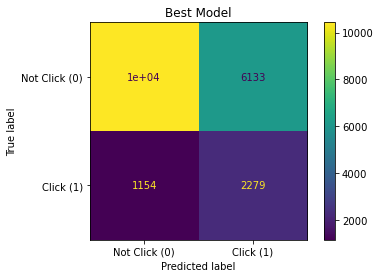

In [24]:
plot_confusion_matrix(best_model, X_test, y_test, display_labels=['Not Click (0)','Click (1)'])
plt.title('Best Model')
plt.show()

Text(0.5, 1.0, 'Best Model')

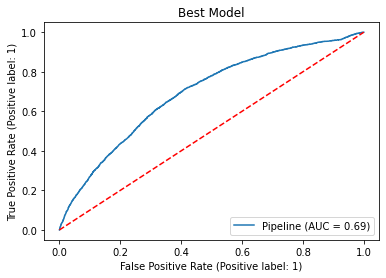

In [25]:
plot_roc_curve(best_model, X_test, y_test) 
plt.plot([0, 1], [0, 1],'r--')
plt.title('Best Model')

plt.show()